## 1. Import Libraries and Setup Environment

In [ ]:
# Local environment - no drive mounting needed
import os

# Define base paths for local environment using relative paths
BASE_PATH = os.path.abspath('.')  # Current directory
MELD_RAW_PATH = os.path.join(BASE_PATH, 'MELD.raw')
SPECTROGRAMS_PATH = os.path.join(BASE_PATH, 'MELD_spectrograms')

print(f"Base path: {BASE_PATH}")
print(f"MELD raw data: {MELD_RAW_PATH}")
print(f"Spectrograms: {SPECTROGRAMS_PATH}")
print("\n✓ Local paths configured!")

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (LSTM, Dense, Dropout, Conv1D, Conv2D,
                                      MaxPooling1D, MaxPooling2D, Flatten,
                                      Input, Concatenate, Average, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print("Libraries imported successfully!")

TensorFlow version: 2.19.0
NumPy version: 2.0.2
Pandas version: 2.2.2
Libraries imported successfully!


In [ ]:
# Local environment - data is already available locally
import os
import glob

# Verify local paths exist
if os.path.exists(MELD_RAW_PATH):
    print(f"✅ MELD raw data found at: {MELD_RAW_PATH}")
    
    # Check for CSV files
    csv_files = glob.glob(os.path.join(MELD_RAW_PATH, "*.csv"))
    print(f"   Found {len(csv_files)} CSV files")
    for csv in csv_files:
        print(f"   - {os.path.basename(csv)}")
else:
    print(f"❌ Error: MELD raw data not found at {MELD_RAW_PATH}")

if os.path.exists(SPECTROGRAMS_PATH):
    print(f"\n✅ Spectrograms found at: {SPECTROGRAMS_PATH}")
    npy_files = glob.glob(os.path.join(SPECTROGRAMS_PATH, "*.npy"))
    print(f"   Found {len(npy_files)} .npy files")
    for npy in npy_files:
        print(f"   - {os.path.basename(npy)}")
else:
    print(f"❌ Warning: Spectrograms not found at {SPECTROGRAMS_PATH}")

print("\n🚀 Ready to go with local data!")

KeyboardInterrupt: 

## 2. Load Pre-computed Embeddings

## Upload PKL (For Text)

In [ ]:
# Local environment - look for text_emotion.pkl in local directory
import os

# Check if pkl file exists locally
pkl_path = os.path.join(BASE_PATH, 'text_emotion.pkl')

if os.path.exists(pkl_path):
    print(f"✅ Found 'text_emotion.pkl' at: {pkl_path}")
else:
    print(f"⚠️ 'text_emotion.pkl' not found at: {pkl_path}")
    print("   Please ensure the file exists in the workspace directory.")
    print("   If you need to generate it, you'll need to run the text embedding extraction code.")

Please upload 'text_emotion.pkl'


Saving text_emotion.pkl to text_emotion.pkl

Files uploaded successfully!
Uploaded files: ['text_emotion.pkl']


In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.preprocessing import LabelEncoder

# --- 1. Load Text Embeddings ---
print("Step 1: Loading Text Embeddings...")
# Use local path
pkl_path = os.path.join(BASE_PATH, 'text_emotion.pkl')

if not os.path.exists(pkl_path):
    print("❌ ERROR: 'text_emotion.pkl' not found.")
    print(f"   Expected location: {pkl_path}")
else:
    with open(pkl_path, 'rb') as f:
        text_data = pickle.load(f)

    # --- 2. Load Labels from CSV ---
    print("Step 2: Loading CSV Labels...")

    train_labels_df = pd.read_csv(os.path.join(MELD_RAW_PATH, 'train_sent_emo.csv'))
    dev_labels_df = pd.read_csv(os.path.join(MELD_RAW_PATH, 'dev_sent_emo.csv'))
    test_labels_df = pd.read_csv(os.path.join(MELD_RAW_PATH, 'test_sent_emo.csv'))

    # Helper to map IDs to Emotions
    def create_label_dict(df):
        label_dict = {}
        for _, row in df.iterrows():
            label_dict[(row['Dialogue_ID'], row['Utterance_ID'])] = row['Emotion']
        return label_dict

    train_label_dict = create_label_dict(train_labels_df)
    dev_label_dict = create_label_dict(dev_labels_df)
    test_label_dict = create_label_dict(test_labels_df)

    # --- 3. Extract IDs and Sync ---
    def extract_ids_and_labels(text_dict, label_dict):
        dia_ids = []
        utt_ids = []
        emotions = []

        for dia_id in text_dict.keys():
            num_utts = text_dict[dia_id].shape[0]
            for utt_idx in range(num_utts):
                key = (int(dia_id), utt_idx)
                if key in label_dict:
                    dia_ids.append(dia_id)
                    utt_ids.append(utt_idx)
                    emotions.append(label_dict[key])

        return dia_ids, utt_ids, emotions

    print("Step 3: Generating ID lists...")
    train_text_dict, val_text_dict, test_text_dict = text_data

    # Create the variables for matching with spectrograms
    train_dia_ids, train_utt_ids, train_emotions = extract_ids_and_labels(train_text_dict, train_label_dict)
    val_dia_ids, val_utt_ids, val_emotions = extract_ids_and_labels(val_text_dict, dev_label_dict)
    test_dia_ids, test_utt_ids, test_emotions = extract_ids_and_labels(test_text_dict, test_label_dict)

    # --- 4. ENCODE LABELS (CRITICAL ADDITION) ---
    print("Step 4: Encoding Labels...")
    le = LabelEncoder()
    # Fit on all emotions to ensure consistent mapping
    le.fit(train_emotions + val_emotions + test_emotions)

    # Create the 'y' variables required by the spectrogram script
    y_train = le.transform(train_emotions)
    y_val = le.transform(val_emotions)
    y_test = le.transform(test_emotions)

    print(f"✅ Success! Variables restored and encoded.")
    print(f"Train samples: {len(y_train)}")
    print(f"Classes: {le.classes_}")

Step 1: Loading Text Embeddings...
Step 2: Loading CSV Labels...
Step 3: Generating ID lists...
Step 4: Encoding Labels...
✅ Success! Variables restored and encoded.
Train samples: 9989
Classes: ['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']


In [ ]:
import numpy as np
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

# ==========================================
# 1. LOAD SPECTROGRAM DATA FROM LOCAL DIRECTORY
# ==========================================

print(f"⏳ Loading spectrogram data from: {SPECTROGRAMS_PATH}")

try:
    # Load the Spectrogram Data (X) - Should be (N, Height, Width, Channels)
    X_audio_train = np.load(os.path.join(SPECTROGRAMS_PATH, 'X_audio_train.npy'))
    X_audio_val = np.load(os.path.join(SPECTROGRAMS_PATH, 'X_audio_val.npy'))
    X_audio_test = np.load(os.path.join(SPECTROGRAMS_PATH, 'X_audio_test.npy'))

    print(f"✅ Loaded Spectrogram Data. Shape: {X_audio_train.shape}")

    # Verify it's proper 4D spectrogram data (Batch, Height, Width, Channels)
    if X_audio_train.ndim != 4:
        raise ValueError(f"Expected 4D spectrogram data (N, H, W, C), got shape {X_audio_train.shape}")

    print(f"✅ Verified: Data is in correct 2D spectrogram format")
    print(f"   - Training samples: {X_audio_train.shape[0]}")
    print(f"   - Spectrogram size: {X_audio_train.shape[1]}x{X_audio_train.shape[2]}")
    print(f"   - Channels: {X_audio_train.shape[3]}")

except FileNotFoundError:
    print(f"❌ Error: Files not found in {SPECTROGRAMS_PATH}. Please check your local directory.")
    raise
except ValueError as e:
    print(f"❌ Error: {e}")
    print("   Make sure you've generated spectrograms (not using old pkl files)")
    raise

# ==========================================
# 2. BUILD 2D CNN FOR SPECTROGRAMS
# ==========================================
def build_2d_cnn_model(input_shape, num_classes):
    """
    Build a 2D CNN model for spectrogram-based emotion classification

    Args:
        input_shape: Shape of input spectrograms (height, width, channels)
        num_classes: Number of emotion classes

    Returns:
        Compiled Keras model
    """
    model = Sequential(name='CNN_Spectrogram_Model')

    # Block 1 - Initial feature extraction
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Block 2 - Deeper features
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Block 3 - High-level features
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Block 4 - Additional depth for complex patterns
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # Flatten & Dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Check dependencies
if 'num_classes' not in locals():
    print("⚠️ 'num_classes' not found. Defaulting to 7.")
    num_classes = 7

# Build and Summarize
cnn_input_shape = X_audio_train.shape[1:]
print(f"\nBuilding CNN model with input shape: {cnn_input_shape}")

cnn_model = build_2d_cnn_model(cnn_input_shape, num_classes)
cnn_model.summary()

print("\n🚀 SUCCESS! CNN model is built and ready for training on spectrograms.")

⏳ Loading spectrogram data from: /content/drive/MyDrive/DS 340 Project
✅ Loaded Spectrogram Data. Shape: (9989, 128, 128, 1)
✅ Verified: Data is in correct 2D spectrogram format
   - Training samples: 9989
   - Spectrogram size: 128x128
   - Channels: 1
⚠️ 'num_classes' not found. Defaulting to 7.

Building CNN model with input shape: (128, 128, 1)


Model: "CNN_Spectrogram_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,618,119 (17.62 MB)

 Trainable params: 4,617,159 (17.61 MB)

 Non-trainable params: 960 (3.75 KB)


🚀 SUCCESS! CNN model is built and ready for training on spectrograms.


In [ ]:
# =============================================================================
# NOTE: THIS SECTION IS OUTDATED - AUDIO NOW USES SPECTROGRAMS
# =============================================================================
# Previously, audio was loaded from 'audio_emotion.pkl' as 1D feature vectors.
# NOW: Audio is processed as 2D spectrograms and loaded from .npy files.
# Text embeddings still use pkl format below.
# =============================================================================

import pickle
import os

# Load text embeddings (contextual features format) from local directory
pkl_path = os.path.join(BASE_PATH, 'text_emotion.pkl')

if os.path.exists(pkl_path):
    with open(pkl_path, 'rb') as f:
        text_data = pickle.load(f)

    print("Text data loaded successfully!")
    print(f"Text data type: {type(text_data)}")
    print("\n⚠️  NOTE: Audio is NO LONGER loaded from pkl files.")
    print("    Audio now uses spectrograms loaded from .npy files (see later cells).\n")

    # Check if it's the contextual features format: [train_dict, val_dict, test_dict]
    if isinstance(text_data, list) and len(text_data) == 3:
        print(f"✓ Detected contextual features format (train/val/test splits)")
        print(f"Text data structure: List of {len(text_data)} dictionaries")

        # Examine train split
        train_text = text_data[0]
        print(f"\nTrain split:")
        print(f"  Text dialogues: {len(train_text)}")

        # Get a sample dialogue
        sample_dia_id = list(train_text.keys())[0]
        sample_text_shape = train_text[sample_dia_id].shape
        print(f"  Sample dialogue '{sample_dia_id}':")
        print(f"    Text shape: {sample_text_shape} (max_utts, text_features)")
    else:
        print(f"\n⚠ Unexpected data format. Expected list of 3 dicts.")
        if isinstance(text_data, list):
            print(f"Text data length: {len(text_data)}")
            if len(text_data) > 0:
                print(f"First element type: {type(text_data[0])}")
        elif isinstance(text_data, dict):
            print(f"Text data keys: {list(text_data.keys())[:5]}...")
else:
    print(f"❌ Error: 'text_emotion.pkl' not found at {pkl_path}")
    print("   Please ensure the file exists in the workspace directory.")

Text data loaded successfully!
Text data type: <class 'list'>

⚠️  NOTE: Audio is NO LONGER loaded from pkl files.
    Audio now uses spectrograms loaded from .npy files (see later cells).

✓ Detected contextual features format (train/val/test splits)
Text data structure: List of 3 dictionaries

Train split:
  Text dialogues: 1038
  Sample dialogue '0':
    Text shape: (33, 600) (max_utts, text_features)


## 3. Explore and Preprocess Data

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os

# --- DEFINE LOCAL PATHS ---
print(f"MELD Root Directory (Local): {MELD_RAW_PATH}")
print("=" * 50)


# Extract features and labels from the contextual features format
if isinstance(text_data, list) and len(text_data) == 3 and isinstance(text_data[0], dict):
    print("\nProcessing contextual features format...")
    print("=" * 50)

    # ============================================================
    # LOAD LABELS FIRST
    # ============================================================
    print("\nLoading MELD CSV labels...")

    # Define full paths for CSVs (local)
    train_csv_path = os.path.join(MELD_RAW_PATH, 'train_sent_emo.csv')
    dev_csv_path = os.path.join(MELD_RAW_PATH, 'dev_sent_emo.csv')
    test_csv_path = os.path.join(MELD_RAW_PATH, 'test_sent_emo.csv')

    # Load CSV files using the local paths
    train_labels_df = pd.read_csv(train_csv_path)
    dev_labels_df = pd.read_csv(dev_csv_path)
    test_labels_df = pd.read_csv(test_csv_path)

    print(f"✓ Loaded CSV files:")
    print(f"  Train: {len(train_labels_df)} labeled utterances (Source: {train_csv_path})")
    print(f"  Dev: {len(dev_labels_df)} labeled utterances")
    print(f"  Test: {len(test_labels_df)} labeled utterances")
    print(f"  Total: {len(train_labels_df) + len(dev_labels_df) + len(test_labels_df)} labeled utterances")

    # Create label lookup dictionaries for fast matching
    def create_label_dict(df):
        """Create a dictionary: (dialogue_id, utterance_id) -> emotion"""
        label_dict = {}
        for _, row in df.iterrows():
            # MELD often uses 1-based indexing in CSVs, but code uses 0-based
            label_dict[(row['Dialogue_ID'], row['Utterance_ID'])] = row['Emotion']       # 1-based (for safety)
            label_dict[(row['Dialogue_ID'], row['Utterance_ID'] - 1)] = row['Emotion']   # 0-based (for processing)
        return label_dict

    train_label_dict = create_label_dict(train_labels_df)
    dev_label_dict = create_label_dict(dev_labels_df)
    test_label_dict = create_label_dict(test_labels_df)

    # ============================================================
    # EXTRACT TEXT UTTERANCES - ONLY KEEP THOSE WITH LABELS
    # ============================================================
    # NOTE: Audio is now processed separately as spectrograms (see later cells)

    def extract_text_utterances_with_labels(text_dict, label_dict):
        """
        Extract text utterances that have corresponding labels in the CSV
        Returns IDs that will be used to match with spectrogram data
        """
        X_text_list = []
        y_list = []
        dialogue_ids = []
        utterance_ids = []

        matched = 0
        total = 0

        for dia_id in text_dict.keys():
            text_features = text_dict[dia_id]

            for utt_idx in range(text_features.shape[0]):
                total += 1
                # Check if utterance is non-zero
                if np.any(text_features[utt_idx]):
                    # Check if we have a label for this utterance
                    key = (int(dia_id), utt_idx)

                    if key in label_dict:
                        X_text_list.append(text_features[utt_idx])
                        y_list.append(label_dict[key])
                        dialogue_ids.append(dia_id)
                        utterance_ids.append(utt_idx)
                        matched += 1

        print(f"  Matched {matched}/{total} utterances with labels ({matched/total*100:.1f}%)")
        return (np.array(X_text_list), y_list, dialogue_ids, utterance_ids)

    # Process all three splits (TEXT ONLY - Audio loaded separately)
    train_text_dict, val_text_dict, test_text_dict = text_data

    print("\nExtracting text utterances with labels...")
    print("Train split:")
    X_text_train, train_emotions, train_dia_ids, train_utt_ids = \
        extract_text_utterances_with_labels(train_text_dict, train_label_dict)

    print("Validation split:")
    X_text_val, val_emotions, val_dia_ids, val_utt_ids = \
        extract_text_utterances_with_labels(val_text_dict, dev_label_dict)

    print("Test split:")
    X_text_test, test_emotions, test_dia_ids, test_utt_ids = \
        extract_text_utterances_with_labels(test_text_dict, test_label_dict)

    print("\n⚠️  NOTE: Audio spectrograms will be loaded from .npy files in later cells")

    print(f"\n✓ Extracted text utterances with labels:")
    print(f"  Train: {len(X_text_train)} utterances")
    print(f"  Val: {len(X_text_val)} utterances")
    print(f"  Test: {len(X_text_test)} utterances")
    print(f"  Total: {len(X_text_train) + len(X_text_val) + len(X_text_test)} utterances")

    # ============================================================
    # ENCODE LABELS
    # ============================================================
    le = LabelEncoder()
    all_emotions = train_emotions + val_emotions + test_emotions
    le.fit(all_emotions)

    y_train = le.transform(train_emotions)
    y_val = le.transform(val_emotions)
    y_test = le.transform(test_emotions)

    # Combine text data (Audio loaded separately as spectrograms)
    X_text = np.vstack([X_text_train, X_text_val, X_text_test])
    y = np.concatenate([y_train, y_val, y_test])

    print(f"\n✓ REAL LABELS LOADED SUCCESSFULLY!")
    print(f"  Emotion classes: {le.classes_}")
    print(f"  Number of classes: {len(le.classes_)}")

    # Show class distribution
    print(f"\nClass distribution:")
    for i, emotion in enumerate(le.classes_):
        count = np.sum(y == i)
        percentage = (count / len(y)) * 100
        print(f"  {emotion}: {count} ({percentage:.2f}%)")

else:
    print("⚠ Unexpected data format. Please check your pickle files.")
    X_text = None
    y = None

print("\n" + "=" * 50)
print("TEXT DATA SUMMARY")
print("=" * 50)
if X_text is not None:
    print(f"Text embeddings shape: {X_text.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Labels are: REAL MELD emotions ✓")
    print(f"\n⚠️  Audio spectrograms are loaded separately from .npy files")
    print(f"Text data ready for LSTM model training!")
else:
    print("No data loaded.")

MELD Root Directory (Drive): /content/drive/My Drive/DS 340 Project/MELD.Raw

Processing contextual features format...

Loading MELD CSV labels...
✓ Loaded CSV files:
  Train: 9989 labeled utterances (Source: /content/drive/My Drive/DS 340 Project/MELD.Raw/train_sent_emo.csv)
  Dev: 1109 labeled utterances
  Test: 2610 labeled utterances
  Total: 13708 labeled utterances

Extracting text utterances with labels...
Train split:
  Matched 10068/34254 utterances with labels (29.4%)
Validation split:
  Matched 1111/3762 utterances with labels (29.5%)
Test split:
  Matched 2612/9240 utterances with labels (28.3%)

⚠️  NOTE: Audio spectrograms will be loaded from .npy files in later cells

✓ Extracted text utterances with labels:
  Train: 10068 utterances
  Val: 1111 utterances
  Test: 2612 utterances
  Total: 13791 utterances

✓ REAL LABELS LOADED SUCCESSFULLY!
  Emotion classes: ['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
  Number of classes: 7

Class distribution:
  ang

TEXT DATA ANALYSIS

Missing values in text embeddings: 0

⚠️  NOTE: Audio spectrograms are loaded separately from .npy files

Unique emotions: [0 1 2 3 4 5 6]
Number of emotion classes: 7


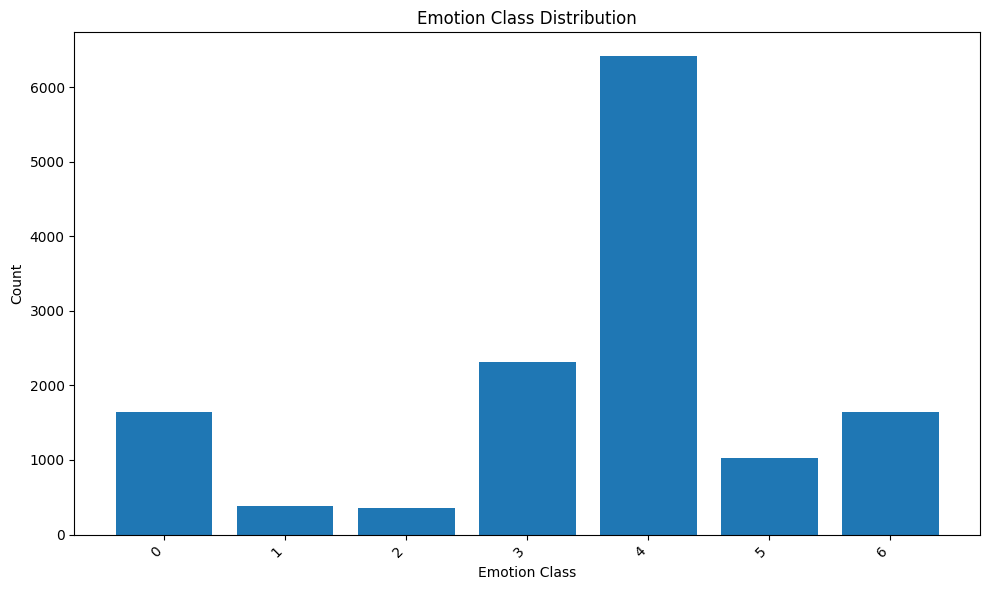


Class distribution:
  0: 1640 samples (11.89%)
  1: 382 samples (2.77%)
  2: 358 samples (2.60%)
  3: 2321 samples (16.83%)
  4: 6416 samples (46.52%)
  5: 1027 samples (7.45%)
  6: 1647 samples (11.94%)


In [ ]:
# Analyze the data
print("=" * 50)
print("TEXT DATA ANALYSIS")
print("=" * 50)

# Check for missing values
print(f"\nMissing values in text embeddings: {np.isnan(X_text).sum()}")
print(f"\n⚠️  NOTE: Audio spectrograms are loaded separately from .npy files")

# Get unique emotion labels
if y is not None:
    unique_emotions = np.unique(y)
    print(f"\nUnique emotions: {unique_emotions}")
    print(f"Number of emotion classes: {len(unique_emotions)}")

    # Encode labels if they're strings
    if isinstance(y[0], str):
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
        emotion_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        print(f"\nEmotion mapping: {emotion_mapping}")
    else:
        y_encoded = y
        label_encoder = None

    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(range(len(unique)), counts)
    plt.xlabel('Emotion Class')
    plt.ylabel('Count')
    plt.title('Emotion Class Distribution')
    plt.xticks(range(len(unique)), unique, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(f"\nClass distribution:")
    for emotion, count in zip(unique, counts):
        print(f"  {emotion}: {count} samples ({count/len(y)*100:.2f}%)")

In [ ]:
# Prepare data for neural networks
if y is not None:
    # Convert labels to categorical (one-hot encoding)
    num_classes = len(unique_emotions)
    y_categorical = to_categorical(y_encoded, num_classes=num_classes)

    # Reshape embeddings if needed for LSTM (needs 3D: samples, timesteps, features)
    if len(X_text.shape) == 2:
        # Assuming each embedding is a single timestep
        X_text_reshaped = X_text.reshape(X_text.shape[0], 1, X_text.shape[1])
    else:
        X_text_reshaped = X_text

    print(f"\nReshaped text embeddings: {X_text_reshaped.shape}")
    print(f"Categorical labels shape: {y_categorical.shape}")
    print(f"\n⚠️  NOTE: Audio spectrograms loaded separately (not split here)")

    # Split TEXT data into train, validation, and test sets (70/15/15)
    # Audio spectrograms are already split and saved as separate .npy files
    # First split: 70% train, 30% temp
    X_text_train, X_text_temp, y_train, y_temp = train_test_split(
        X_text_reshaped, y_categorical,
        test_size=0.30, random_state=42, stratify=y_encoded
    )

    # Second split: split temp into 50/50 for validation and test (15% each of total)
    X_text_val, X_text_test, y_val, y_test = train_test_split(
        X_text_temp, y_temp,
        test_size=0.50, random_state=42, stratify=np.argmax(y_temp, axis=1)
    )

    print(f"\n{'='*50}")
    print("DATA SPLIT")
    print(f"{'='*50}")
    print(f"Training set: {X_text_train.shape[0]} samples ({X_text_train.shape[0]/X_text_reshaped.shape[0]*100:.1f}%)")
    print(f"Validation set: {X_text_val.shape[0]} samples ({X_text_val.shape[0]/X_text_reshaped.shape[0]*100:.1f}%)")
    print(f"Test set: {X_text_test.shape[0]} samples ({X_text_test.shape[0]/X_text_reshaped.shape[0]*100:.1f}%)")
else:
    print("\nWarning: No labels found in data. Please check the data structure.")


Reshaped text embeddings: (13791, 1, 600)
Categorical labels shape: (13791, 7)

⚠️  NOTE: Audio spectrograms loaded separately (not split here)

DATA SPLIT
Training set: 9653 samples (70.0%)
Validation set: 2069 samples (15.0%)
Test set: 2069 samples (15.0%)


In [ ]:
import numpy as np
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

# Load Spectrogram Data from local directory
print("⏳ Loading spectrogram data from local directory...")

X_audio_train = np.load(os.path.join(SPECTROGRAMS_PATH, 'X_audio_train.npy'))
X_audio_val = np.load(os.path.join(SPECTROGRAMS_PATH, 'X_audio_val.npy'))
X_audio_test = np.load(os.path.join(SPECTROGRAMS_PATH, 'X_audio_test.npy'))

print(f"✅ Loaded Spectrogram Data. Shape: {X_audio_train.shape}")

# Verify Spectrogram Format
if X_audio_train.ndim != 4:
    raise ValueError(f"Expected 4D spectrogram data (N, H, W, C), got shape {X_audio_train.shape}. "
                     "Make sure you're using spectrograms, not old pkl files.")

print(f"   - Training samples: {X_audio_train.shape[0]}")
print(f"   - Spectrogram size: {X_audio_train.shape[1]}x{X_audio_train.shape[2]}")
print(f"   - Channels: {X_audio_train.shape[3]}")

# Build 2D CNN for Spectrograms
def build_2d_cnn_model(input_shape, num_classes):
    model = Sequential(name='CNN_Spectrogram_Model')

    # Block 1 - Initial feature extraction
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Block 2 - Deeper features
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Block 3 - High-level features
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Block 4 - Complex patterns
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # Dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Build Model
if 'num_classes' not in locals():
    num_classes = 7

cnn_input_shape = X_audio_train.shape[1:]
print(f"\nBuilding CNN with input shape: {cnn_input_shape}")
cnn_model = build_2d_cnn_model(cnn_input_shape, num_classes)
cnn_model.summary()

print("\n🚀 Success! CNN model built and ready for training on spectrograms.")

⏳ Loading spectrogram data from Drive...
✅ Loaded Spectrogram Data. Shape: (9989, 128, 128, 1)
   - Training samples: 9989
   - Spectrogram size: 128x128
   - Channels: 1

Building CNN with input shape: (128, 128, 1)


Model: "CNN_Spectrogram_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,618,119 (17.62 MB)

 Trainable params: 4,617,159 (17.61 MB)

 Non-trainable params: 960 (3.75 KB)


🚀 Success! CNN model built and ready for training on spectrograms.


## 4. Build LSTM Model for Text Embeddings

In [ ]:
def build_lstm_model(input_shape, num_classes):
    """
    Build LSTM model for text emotion classification

    Args:
        input_shape: Shape of input (timesteps, features)
        num_classes: Number of emotion classes

    Returns:
        Compiled Keras model
    """
    model = Sequential(name='LSTM_Text_Model')

    # LSTM layers with dropout for regularization
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer with softmax for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build the LSTM model
lstm_input_shape = (X_text_train.shape[1], X_text_train.shape[2])
lstm_model = build_lstm_model(lstm_input_shape, num_classes)

# Display model architecture
lstm_model.summary()

Model: "LSTM_Text_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │       373,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,895 (1.64 MB)

 Trainable params: 429,511 (1.64 MB)

 Non-trainable params: 384 (1.50 KB)

## 5. Build CNN Model for Audio Embeddings

In [ ]:
import numpy as np
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.utils import class_weight

# =========================================================================
# 2. Load the Spectrograms from Local Directory
# =========================================================================
# IMPORTANT: These spectrograms were generated using the EXACT same
# train_dia_ids, val_dia_ids, and test_dia_ids that were used to create
# y_train, y_val, and y_test. This means they are already synchronized!
# =========================================================================

print("⏳ Loading spectrograms from local directory...")
print("   These were generated from the filtered ID lists, ensuring alignment.\n")

try:
    X_audio_train = np.load(os.path.join(SPECTROGRAMS_PATH, 'X_audio_train.npy'))
    X_audio_val = np.load(os.path.join(SPECTROGRAMS_PATH, 'X_audio_val.npy'))
    X_audio_test = np.load(os.path.join(SPECTROGRAMS_PATH, 'X_audio_test.npy'))
    print(f"✅ Success! Data Loaded.")
    print(f"   Train Shape: {X_audio_train.shape}")
    print(f"   Val Shape:   {X_audio_val.shape}")
    print(f"   Test Shape:  {X_audio_test.shape}")

    # Verify alignment with labels
    if 'y_train' in locals():
        print(f"\n🔍 Verifying alignment with labels:")
        print(f"   y_train shape:  {y_train.shape}")
        print(f"   y_val shape:    {y_val.shape}")
        print(f"   y_test shape:   {y_test.shape}")

        if X_audio_train.shape[0] == y_train.shape[0]:
            print(f"\n✅ Perfect alignment! Train: {X_audio_train.shape[0]} samples")
        else:
            print(f"\n⚠️  Size mismatch detected:")
            print(f"   Train: {X_audio_train.shape[0]} spectrograms vs {y_train.shape[0]} labels")
            print(f"   You may need to regenerate spectrograms using the filtered ID lists.")

except FileNotFoundError:
    print(f"❌ Error: Could not find .npy files in local directory.")
    print(f"Checked path: {SPECTROGRAMS_PATH}")
    print("Please make sure the files 'X_audio_train.npy' etc. exist in that folder.")


import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras.models import Model

# =========================================================================
# ⚠️ 3. CALCULATE AND DEFINE CLASS WEIGHTS (FIXED)
# =========================================================================

if 'y_train' in locals():
    print("\n⚖️ Calculating balanced class weights...")

    # --- FIX: Ensure y_train is a 1-dimensional integer array ---

    # If y_train is a NumPy array, try to flatten it.
    if isinstance(y_train, np.ndarray):
        y_train_flat = y_train.flatten()
        print(f"✓ y_train reshaped from {y_train.shape} to {y_train_flat.shape}")
    else:
        # If it's a list of lists/arrays, convert to NumPy and flatten
        y_train_flat = np.array(y_train).flatten()
        print("✓ y_train converted and flattened.")

    # 1. Calculate the weight for each unique class in the training set
    class_weights_array = class_weight.compute_class_weight(
        class_weight='balanced',
        # Use the flattened array for calculation
        classes=np.unique(y_train_flat),
        y=y_train_flat
    )

    # 2. Convert the resulting array into the dictionary format required by Keras
    class_weights_dict = dict(enumerate(class_weights_array))

    print("✓ Class weights calculated.")
    print(f"   Class weights: {class_weights_dict}")

else:
    print("❌ ERROR: 'y_train' not found. Cannot calculate class weights.")
    class_weights_dict = {}


# 4. Define the 2D CNN Architecture
def build_2d_cnn_model(input_shape, num_classes):
    model = Sequential(name='CNN_Spectrogram_Model')

    # Conv Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Conv Block 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Conv Block 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Flatten & Dense
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# 5. Build the Model
if 'num_classes' not in locals():
    print("⚠️ 'num_classes' not found. Defaulting to 7 (standard for MELD).")
    num_classes = 7

if 'X_audio_train' in locals():
    cnn_input_shape = X_audio_train.shape[1:]

    print(f"\nBuilding model with input shape: {cnn_input_shape}")
    cnn_model = build_2d_cnn_model(cnn_input_shape, num_classes)
    cnn_model.summary()
    print("\n🚀 Model is ready for training!")
else:
    print("❌ Cannot build model: Data failed to load.")

⏳ Loading spectrograms from Google Drive...
   These were generated from the filtered ID lists, ensuring alignment.

✅ Success! Data Loaded.
   Train Shape: (9989, 128, 128, 1)
   Val Shape:   (1109, 128, 128, 1)
   Test Shape:  (2610, 128, 128, 1)

🔍 Verifying alignment with labels:
   y_train shape:  (9989,)
   y_val shape:    (1109,)
   y_test shape:   (2610,)

✅ Perfect alignment! Train: 9989 samples

⚖️ Calculating balanced class weights...
✓ y_train reshaped from (9989,) to (9989,)
✓ Class weights calculated.

Building model with input shape: (128, 128, 1)


Model: "CNN_Spectrogram_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,863 (12.61 MB)

 Trainable params: 3,305,415 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)


🚀 Model is ready for training!


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

def build_2d_cnn_model(input_shape, num_classes):
    """
    Builds a 2D CNN for Spectrogram Image classification.
    input_shape should be (n_mels, max_time_steps, 1) -> e.g., (128, 128, 1)
    """
    model = Sequential(name='CNN_Spectrogram_Model')

    # Convolution Block 1
    # Note: We use Conv2D now instead of Conv1D
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Convolution Block 2
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Convolution Block 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

## 6. Train LSTM Model Independently

In [ ]:
# Compile LSTM model
lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
lstm_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_lstm_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Training LSTM model...")
print("=" * 50)

# Train the model
lstm_history = lstm_model.fit(
    X_text_train, y_train,
    validation_data=(X_text_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=lstm_callbacks,
    verbose=1
)

print("\n✓ LSTM model training complete!")

Training LSTM model...
Epoch 1/100
300/302 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3507 - loss: 1.7828
Epoch 1: val_accuracy improved from -inf to 0.53214, saving model to best_lstm_model.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3516 - loss: 1.7806 - val_accuracy: 0.5321 - val_loss: 1.5812 - learning_rate: 0.0010
Epoch 2/100
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5115 - loss: 1.4059
Epoch 2: val_accuracy improved from 0.53214 to 0.54326, saving model to best_lstm_model.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5116 - loss: 1.4057 - val_accuracy: 0.5433 - val_loss: 1.3726 - learning_rate: 0.0010
Epoch 3/100
297/302 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5315 - loss: 1.3540
Epoch 3: val_accuracy improved from 0.54326 to 0.57371, saving model to best_lstm_model.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5317 - loss: 1.3535 - val_accuracy: 0.5737 - val_loss: 1.2755 - learning_rate: 0.0010
Epoch 4/100
3

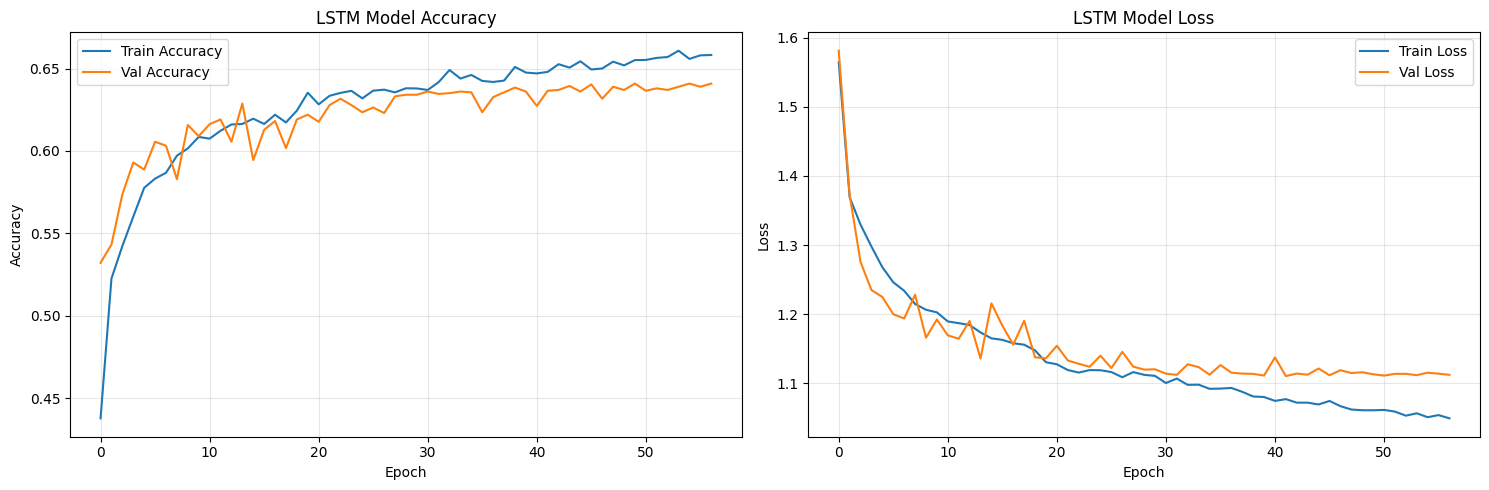


Final Training Accuracy: 0.6582
Final Validation Accuracy: 0.6409
Best Validation Accuracy: 0.6409


In [ ]:
# Plot LSTM training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(lstm_history.history['accuracy'], label='Train Accuracy')
axes[0].plot(lstm_history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('LSTM Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(lstm_history.history['loss'], label='Train Loss')
axes[1].plot(lstm_history.history['val_loss'], label='Val Loss')
axes[1].set_title('LSTM Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Accuracy: {lstm_history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {lstm_history.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(lstm_history.history['val_accuracy']):.4f}")

## 7. Train CNN Model Independently

In [ ]:
# =========================================================================
# CRITICAL: NO TRIMMING NEEDED - Arrays are already synchronized!
# =========================================================================
# The spectrograms in X_audio_train were generated using the EXACT same
# train_dia_ids and train_utt_ids that were used to create y_train.
# This means the i-th spectrogram corresponds to the i-th label by design.
#
# The previous trimming code was a symptom of the problem, not the solution.
# By generating spectrograms ONLY for the filtered ID lists from the label
# processing step, we ensure perfect 1:1 correspondence from the start.
# =========================================================================

# Verify alignment (should already be equal)
print(f"\nVerifying data alignment:")
print(f"  X_audio_train shape: {X_audio_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  X_audio_val shape: {X_audio_val.shape}")
print(f"  y_val shape: {y_val.shape}")
print(f"  X_audio_test shape: {X_audio_test.shape}")
print(f"  y_test shape: {y_test.shape}")

# Sanity check: Sizes should match exactly
assert X_audio_train.shape[0] == y_train.shape[0], \
    f"❌ Train size mismatch: {X_audio_train.shape[0]} spectrograms vs {y_train.shape[0]} labels"
assert X_audio_val.shape[0] == y_val.shape[0], \
    f"❌ Val size mismatch: {X_audio_val.shape[0]} spectrograms vs {y_val.shape[0]} labels"
assert X_audio_test.shape[0] == y_test.shape[0], \
    f"❌ Test size mismatch: {X_audio_test.shape[0]} spectrograms vs {y_test.shape[0]} labels"

print("\n✅ All arrays are properly aligned!")

# Compile CNN model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
cnn_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_cnn_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\nTraining CNN model...")
print("=" * 50)

from tensorflow.keras.utils import to_categorical

# 1. Convert integer labels to One-Hot Encoding
# Ensure you use the correct number of classes (7 for MELD)
num_classes = 7
y_train_ohe = to_categorical(y_train, num_classes=num_classes)
y_val_ohe = to_categorical(y_val, num_classes=num_classes)


# Cap the weights to prevent instability
for k, v in class_weights_dict.items():
    class_weights_dict[k] = min(v, 3.0)

# Train the model with properly aligned data
cnn_history = cnn_model.fit(
    X_audio_train, y_train_ohe,  # Use original y_train, not y_train_audio
    validation_data=(X_audio_val, y_val_ohe),
    epochs=100,
    batch_size=32,
    callbacks=cnn_callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

print("\n✓ CNN model training complete!")



Verifying data alignment:
  X_audio_train shape: (9989, 128, 128, 1)
  y_train shape: (9989,)
  X_audio_val shape: (1109, 128, 128, 1)
  y_val shape: (1109,)
  X_audio_test shape: (2610, 128, 128, 1)
  y_test shape: (2610,)

✅ All arrays are properly aligned!

Training CNN model...
Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.4774 - loss: 1.6874
Epoch 1: val_accuracy improved from -inf to 0.38954, saving model to best_cnn_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 154s 484ms/step - accuracy: 0.4774 - loss: 1.6875 - val_accuracy: 0.3895 - val_loss: 1.9161 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.4753 - loss: 1.6753
Epoch 2: val_accuracy did not improve from 0.38954
313/313 ━━━━━━━━━━━━━━━━━━━━ 151s 481ms/step - accuracy: 0.4752 - loss: 1.6753 - val_accuracy: 0.2768 - val_loss: 2.4937 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.4782 - loss: 1.6676
Epoch 3: val_accur

In [ ]:
print("Class Weights being used:", class_weights_dict)

Class Weights being used: {0: np.float64(1.2867448151487826), 1: np.float64(5.265682656826568), 2: np.float64(5.324626865671642), 3: np.float64(0.8187033849684452), 4: np.float64(0.3029723991507431), 5: np.float64(2.089311859443631), 6: np.float64(1.1842323651452282)}


In [ ]:
# Plot CNN training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(cnn_history.history['accuracy'], label='Train Accuracy')
axes[0].plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('CNN Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(cnn_history.history['loss'], label='Train Loss')
axes[1].plot(cnn_history.history['val_loss'], label='Val Loss')
axes[1].set_title('CNN Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Accuracy: {cnn_history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {cnn_history.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(cnn_history.history['val_accuracy']):.4f}")

## 8. Evaluate Individual Models

In [ ]:
def evaluate_model(model, X_test, y_test, model_name, emotion_labels):
    """
    Evaluate a model and display metrics

    Args:
        model: Trained Keras model
        X_test: Test features
        y_test: Test labels (one-hot encoded)
        model_name: Name of the model for display
        emotion_labels: List of emotion label names
    """
    print(f"\n{'='*50}")
    print(f"{model_name} EVALUATION")
    print(f"{'='*50}")

    # Get predictions
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate test accuracy
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification report
    print(f"\n{'-'*50}")
    print("Classification Report:")
    print(f"{'-'*50}")
    print(classification_report(y_true, y_pred, target_names=emotion_labels))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return test_accuracy, y_pred, y_pred_probs

# Get emotion labels for display
if label_encoder is not None:
    emotion_labels = label_encoder.classes_
else:
    emotion_labels = [f"Emotion_{i}" for i in range(num_classes)]

# Evaluate LSTM model
lstm_accuracy, lstm_pred, lstm_pred_probs = evaluate_model(
    lstm_model, X_text_test, y_test, "LSTM (Text)", emotion_labels
)

In [ ]:
# Evaluate CNN model
cnn_accuracy, cnn_pred, cnn_pred_probs = evaluate_model(
    cnn_model, X_audio_test, y_test, "CNN (Audio)", emotion_labels
)

## 9. Build Fusion Model Architecture

In [ ]:
def build_fusion_model(text_input_shape, audio_input_shape, num_classes):
    """
    Build a fusion model that combines LSTM (text) and CNN (audio) outputs

    Args:
        text_input_shape: Shape of text input (timesteps, features)
        audio_input_shape: Shape of audio input (height, width, channels) - for spectrograms
        num_classes: Number of emotion classes

    Returns:
        Compiled Keras model
    """
    # Text input branch (LSTM)
    text_input = Input(shape=text_input_shape, name='text_input')

    # LSTM layers for text
    text_lstm = LSTM(128, return_sequences=True)(text_input)
    text_lstm = Dropout(0.3)(text_lstm)
    text_lstm = BatchNormalization()(text_lstm)

    text_lstm = LSTM(64, return_sequences=False)(text_lstm)
    text_lstm = Dropout(0.3)(text_lstm)
    text_lstm = BatchNormalization()(text_lstm)

    text_dense = Dense(64, activation='relu')(text_lstm)
    text_dense = Dropout(0.3)(text_dense)

    # Audio input branch (2D CNN for Spectrograms)
    audio_input = Input(shape=audio_input_shape, name='audio_input')

    # 2D CNN layers for audio spectrograms
    audio_conv = Conv2D(32, (3, 3), activation='relu', padding='same')(audio_input)
    audio_conv = BatchNormalization()(audio_conv)
    audio_conv = MaxPooling2D(pool_size=(2, 2))(audio_conv)
    audio_conv = Dropout(0.3)(audio_conv)

    audio_conv = Conv2D(64, (3, 3), activation='relu', padding='same')(audio_conv)
    audio_conv = BatchNormalization()(audio_conv)
    audio_conv = MaxPooling2D(pool_size=(2, 2))(audio_conv)
    audio_conv = Dropout(0.3)(audio_conv)

    audio_conv = Conv2D(128, (3, 3), activation='relu', padding='same')(audio_conv)
    audio_conv = BatchNormalization()(audio_conv)
    audio_conv = MaxPooling2D(pool_size=(2, 2))(audio_conv)
    audio_conv = Dropout(0.3)(audio_conv)

    audio_conv = Conv2D(256, (3, 3), activation='relu', padding='same')(audio_conv)
    audio_conv = BatchNormalization()(audio_conv)
    audio_conv = MaxPooling2D(pool_size=(2, 2))(audio_conv)
    audio_conv = Dropout(0.3)(audio_conv)

    audio_flat = Flatten()(audio_conv)
    audio_dense = Dense(128, activation='relu')(audio_flat)
    audio_dense = Dropout(0.4)(audio_dense)
    audio_dense = Dense(64, activation='relu')(audio_dense)
    audio_dense = Dropout(0.3)(audio_dense)

    # Fusion layer - Concatenate both branches
    fusion = Concatenate()([text_dense, audio_dense])

    # Additional fusion layers
    fusion = Dense(128, activation='relu')(fusion)
    fusion = Dropout(0.4)(fusion)
    fusion = BatchNormalization()(fusion)

    fusion = Dense(64, activation='relu')(fusion)
    fusion = Dropout(0.3)(fusion)

    # Output layer
    output = Dense(num_classes, activation='softmax', name='output')(fusion)

    # Create model
    model = Model(inputs=[text_input, audio_input], outputs=output, name='Fusion_Model')

    return model

# Build the fusion model
fusion_model = build_fusion_model(lstm_input_shape, cnn_input_shape, num_classes)

# Display model architecture
fusion_model.summary()


## 10. Train Fusion Model

In [ ]:
# Compile fusion model
fusion_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
fusion_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_fusion_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Training Fusion model...")
print("=" * 50)

# Train the model with both text and audio inputs
fusion_history = fusion_model.fit(
    [X_text_train, X_audio_train], y_train,
    validation_data=([X_text_val, X_audio_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=fusion_callbacks,
    verbose=1
)

print("\n✓ Fusion model training complete!")

In [ ]:
# Plot Fusion model training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(fusion_history.history['accuracy'], label='Train Accuracy')
axes[0].plot(fusion_history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Fusion Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(fusion_history.history['loss'], label='Train Loss')
axes[1].plot(fusion_history.history['val_loss'], label='Val Loss')
axes[1].set_title('Fusion Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Accuracy: {fusion_history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {fusion_history.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(fusion_history.history['val_accuracy']):.4f}")

## 11. Evaluate and Compare Fusion Model

In [ ]:
# Evaluate fusion model
print(f"\n{'='*50}")
print("FUSION MODEL EVALUATION")
print(f"{'='*50}")

# Get predictions
fusion_pred_probs = fusion_model.predict([X_text_test, X_audio_test], verbose=0)
fusion_pred = np.argmax(fusion_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate test accuracy
fusion_test_loss, fusion_accuracy = fusion_model.evaluate(
    [X_text_test, X_audio_test], y_test, verbose=0
)
print(f"\nTest Accuracy: {fusion_accuracy:.4f}")
print(f"Test Loss: {fusion_test_loss:.4f}")

# Classification report
print(f"\n{'-'*50}")
print("Classification Report:")
print(f"{'-'*50}")
print(classification_report(y_true, fusion_pred, target_names=emotion_labels))

# Confusion matrix
cm = confusion_matrix(y_true, fusion_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Fusion Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
# Compare all models
print(f"\n{'='*50}")
print("MODEL COMPARISON")
print(f"{'='*50}")

models_comparison = pd.DataFrame({
    'Model': ['LSTM (Text Only)', 'CNN (Audio Only)', 'Fusion (Text + Audio)'],
    'Test Accuracy': [lstm_accuracy, cnn_accuracy, fusion_accuracy]
})

print(models_comparison.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(models_comparison['Model'], models_comparison['Test Accuracy'],
               color=['#3498db', '#e74c3c', '#2ecc71'])
plt.ylabel('Test Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.0)
plt.xticks(rotation=15, ha='right')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Calculate improvement
improvement_over_lstm = ((fusion_accuracy - lstm_accuracy) / lstm_accuracy) * 100
improvement_over_cnn = ((fusion_accuracy - cnn_accuracy) / cnn_accuracy) * 100

print(f"\nFusion Model Improvements:")
print(f"  Over LSTM: {improvement_over_lstm:+.2f}%")
print(f"  Over CNN: {improvement_over_cnn:+.2f}%")

In [ ]:
# Analyze per-class performance improvements
print(f"\n{'='*50}")
print("PER-CLASS ANALYSIS")
print(f"{'='*50}")

# Get per-class metrics for all models
from sklearn.metrics import precision_recall_fscore_support

# Calculate metrics
lstm_precision, lstm_recall, lstm_f1, _ = precision_recall_fscore_support(
    y_true, lstm_pred, average=None, labels=range(num_classes)
)
cnn_precision, cnn_recall, cnn_f1, _ = precision_recall_fscore_support(
    y_true, cnn_pred, average=None, labels=range(num_classes)
)
fusion_precision, fusion_recall, fusion_f1, _ = precision_recall_fscore_support(
    y_true, fusion_pred, average=None, labels=range(num_classes)
)

# Create comparison dataframe
per_class_df = pd.DataFrame({
    'Emotion': emotion_labels,
    'LSTM F1': lstm_f1,
    'CNN F1': cnn_f1,
    'Fusion F1': fusion_f1,
    'Improvement': fusion_f1 - np.maximum(lstm_f1, cnn_f1)
})

print("\nF1-Score Comparison by Emotion Class:")
print(per_class_df.to_string(index=False))

# Visualize per-class F1 scores
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(emotion_labels))
width = 0.25

bars1 = ax.bar(x - width, lstm_f1, width, label='LSTM', color='#3498db')
bars2 = ax.bar(x, cnn_f1, width, label='CNN', color='#e74c3c')
bars3 = ax.bar(x + width, fusion_f1, width, label='Fusion', color='#2ecc71')

ax.set_xlabel('Emotion Class')
ax.set_ylabel('F1-Score')
ax.set_title('Per-Class F1-Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(emotion_labels, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nEmotions with highest fusion improvement:")
top_improvements = per_class_df.nlargest(3, 'Improvement')
for _, row in top_improvements.iterrows():
    print(f"  {row['Emotion']}: +{row['Improvement']:.4f}")